# Detecting floating objects using deep learning and Sentinel-2 imagery

{bdg-primary}`Ocean`
{bdg-secondary}`Modelling`
{bdg-warning}`Standard`
{bdg-info}`Python`

<p align="left">
    <a href="https://github.com/eds-book-gallery/b34facfa-cea8-48f5-89f6-f11ce00812a9/blob/main/LICENSE">
        <img alt="license" src="https://img.shields.io/badge/license-MIT-yellow.svg">
    </a>
    <a href="https://github.com/eds-book-gallery/b34facfa-cea8-48f5-89f6-f11ce00812a9/actions/workflows/render.yaml">
        <img alt="render" src="https://github.com/eds-book-gallery/b34facfa-cea8-48f5-89f6-f11ce00812a9/actions/workflows/render.yaml/badge.svg">
    </a>
    <a href="https://github.com/alan-turing-institute/environmental-ds-book/pull/22">
        <img alt="review" src="https://img.shields.io/badge/view-review-purple">
    </a>
    <br/>
</p>

<p align="left">
    <a href="http://mybinder.org/v2/gh/eds-book-gallery/b34facfa-cea8-48f5-89f6-f11ce00812a9/main?labpath=notebook.ipynb">
        <img alt="binder" src="https://mybinder.org/badge_logo.svg">
    </a>
    <a href="https://replay.notebooks.egi.eu/v2/gh/eds-book-gallery/b34facfa-cea8-48f5-89f6-f11ce00812a9/main?labpath=notebook.ipynb">
        <img alt="binder" src="https://img.shields.io/badge/launch-EGI%20binder-F5A252.svg?logo=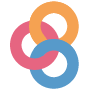">
    </a>
    <br/>
</p>

<p align="left">
    <a href="https://w3id.org/ro-id/b34facfa-cea8-48f5-89f6-f11ce00812a9">
        <img alt="rohub" src="https://img.shields.io/badge/RoHub-FAIR_Executable_Research_Object-2ea44f?logo=Open+Access&logoColor=blue">
    </a>
    <a href="https://zenodo.org/badge/latestdoi/493600192">
        <img alt="doi" src="https://zenodo.org/badge/493600192.svg">
    </a>
</p>

## Context

### Purpose
Detect floating targets that might contain plastic, algea, sargassum, wood, etc. in coastal areas using deep learning methods and Sentinel-2 data.

### Modelling approach

In this notebook we show the potential of deep learning methods to detect and highlight floating debris of various natures in coastal areas. First, the dataset can be downloaded from [Zenodo](https://zenodo.org/record/5827377#.YdgfjGjMK9I) using this notebook and it contains: a Sentinel-2 image over a coastal area of Rio de Janeiro in Brazil, a validation example from the [Plastic Litter Project (PLP)](http://plp.aegean.gr/category/experiment-log-2021/), and two use-case Sentinel-2 images of scenes containing various floating targets. We then apply pre-trained weights in order to identify the potential existence of floating targets. We visualise the results in an interactive way and we also show that the model works on validation data and on examples containing different types of floating objects. We finally export the predictions in Geotiff formats to the output folders. Our experiments were implemented using Pytorch. Further details on the labeled dataset and the code can be found here: https://github.com/ESA-PhiLab/floatingobjects.

### Highlights

* We demonstrate the use of deep neural networks for the detection of floating objects on Sentinel-2 data.
* Once the user downloads the dataset from Zenodo using this notebook, the predictions can be run and the results will be visualised.
* Several use cases are included in order to show the variety of the detected objects.
* The user can visualise the RGB image, the NDVI and FDI indices along with the predictions and classifications.
* The predictions will be available locally in the user's folder.

### Contributions

#### Notebook
* Jamila Mifdal (author), European Space Agency Φ-lab, [@jmifdal](https://github.com/jmifdal)
* Raquel Carmo (author), European Space Agency Φ-lab, [@raquelcarmo](https://github.com/raquelcarmo)
* Alejandro Coca-Castro (reviewer), The Alan Turing Institute, [@acocac](https://github.com/acocac)

#### Modelling codebase
* Jamila Mifdal (author), European Space Agency Φ-lab, [@jmifdal](https://github.com/jmifdal)
* Raquel Carmo (author), European Space Agency Φ-lab, [@raquelcarmo](https://github.com/raquelcarmo)
* Marc Rußwurm (author), EPFL-ECEO, [@marccoru](https://github.com/MarcCoru)

#### Modelling publications
```{bibliography}
  :style: plain
  :list: bullet
  :filter: topic % "b34facfa-cea8-48f5-89f6-f11ce00812a9"
```

#### Modelling funding
This project is supported by [Φ-lab, European Space Agency](https://philab.phi.esa.int/).

## Install and load libraries

In [ ]:
!pip -q install gdown

In [ ]:
import os
import numpy as np

# intake and pooch library
import intake
import pooch

# xarray
import xarray as xr

# machine learning libraries
import torch

# image libraries
from PIL import Image

# visualisation
import rasterio as rio 

import matplotlib, matplotlib.cm
import matplotlib.pyplot as plt

from skimage.exposure import equalize_hist

import holoviews as hv
import hvplot.xarray

import warnings
warnings.filterwarnings(action='ignore')

hv.extension('bokeh', width=100)

## Set folder structure

In [ ]:
# Define the project main folder
data_folder = './notebook'

# Set the folder structure
config = {
    'in_geotiff': os.path.join(data_folder, 'input','tiff'),
    'out_geotiff': os.path.join(data_folder, 'output','raster'),
    'out_usecases': os.path.join(data_folder, 'output','usecases')
}

# List comprehension for the folder structure code
[os.makedirs(val) for key, val in config.items() if not os.path.exists(val)]

## Load and prepare input image

### Fetch input data using `intake`

The input data of this notebook can be fetched directly from a [Zenodo repository](https://zenodo.org/record/5827377#.YdgfjGjMK9I) using `pooch`. We provide the repository's DOI (10.5281/zenodo.5827377) and we set the target entries with corresponding output folders where the downloaded files will be stored.

In [1]:
dataset = pooch.create(
    path=config['in_geotiff'],
    # Use the figshare DOI
    base_url="doi:10.5281/zenodo.5827377/",
    registry={
        "cancun_20180914.tif": "md5:1d4cdb7db75d3ade702767bbfbd3ea44",
        "mytilini_20210621.tif": "md5:36edf5dace9c09914cc5fc3165109462",        
        "RioDeJaneiro.tif": "md5:734ab89c2cbde1ad76b460f4b029d9a6", 
        "tangshan_20180130.tif": "md5:e62f1faf4a6a875c88892efa4fe72723",
    },
)

# Download all the files in a Zenodo record
for fn in dataset.registry_files:
    dataset.fetch(fn)

NameError: name 'pooch' is not defined

In [ ]:
# write a catalog YAML file for GeoTIFF images
catalog_images = os.path.join(data_folder, 'catalog_images.yaml')

with open(catalog_images, 'w') as f:
    f.write('''
plugins:
  source:
    - module: intake_xarray
sources:
  cancun:
    driver: rasterio
    description: 'GeoTIFF image in Cancun'
    args:
      urlpath: "{{ CATALOG_DIR }}/input/tiff/cancun_20180914.tif"
  mytilini:
    driver: rasterio
    description: 'GeoTIFF image in Mytilini'
    args:
      urlpath: "{{ CATALOG_DIR }}/input/tiff/mytilini_20210621.tif"
  riodejaneiro:
    driver: rasterio
    description: 'GeoTIFF image in Rio de Janeiro'
    args:
      urlpath: "{{ CATALOG_DIR }}/input/tiff/RioDeJaneiro.tif"
  tangshan:
    driver: rasterio
    description: 'GeoTIFF image in tangshan'
    args:
      urlpath: "{{ CATALOG_DIR }}/input/tiff/tangshan_20180130.tif"
      ''')

In [ ]:
cat_images = intake.open_catalog(catalog_images)

### Inspect the Sentinel-2 data image
In the example below, we inspect the .tif image provided in the [Zenodo repository](https://zenodo.org/record/5827377#.YdgfjGjMK9I), called "RioDeJaneiro.tif".

Let's investigate the loaded `data-array` fetched by intake.

In [ ]:
image = cat_images['riodejaneiro'].read()

print('shape =', image.shape)

## Compute model predictions
In this work we focus on the spatial patterns of the floating targets, thus we address this detection task as a binary classification problem of floating objects versus water surface. A deep learning-based segmentation model was chosen to perform the detection and delineation of the floating targets: a U-Net Convolutional Neural Network (CNN). This model has been pre-trained on a large open-source hand-labeled Sentinel-2 dataset, developed by the authors, containing both Level-1C Top-Of-Atmosphere (TOA) and Level-2A Bottom-Of-Atmosphere (BOA) products over coastal water bodies. For more details, please refer to https://github.com/ESA-PhiLab/floatingobjects.

### Load the model and its pre-trained weights
For the U-Net, there are two pre-trained models available (described in this [link](https://github.com/ESA-PhiLab/floatingobjects/blob/master/hubconf.py)). For the sake of simplicity we are loading the weights of the 'unet_seed0', which refers to a U-Net architecture pre-trained for 50 epochs, with batch size of 160, learning rate of 0.001 and seed 0.

In [ ]:
#Device to run the computations on
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Available models and weights
unet_seed0 = torch.hub.load('ESA-PhiLab/floatingobjects:master', 'unet_seed0', map_location=torch.device(device))
#unet_seed1 = torch.hub.load('ESA-PhiLab/floatingobjects:master', 'unet_seed1', map_location=torch.device(device))

#Select model
model = unet_seed0

### Compute predictions
Input the image to the model to yield predictions.

In [ ]:
l1cbands = ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9", "B10", "B11", "B12"]
l2abands = ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9", "B11", "B12"]

image = image.assign_coords(band_id=('band', l1cbands))
image = image.set_index(band="band_id")

#If L1C image (13 bands), read only the 12 bands compatible with L2A data
if (image.shape[0] == 13):
    image = image.sel(band=l2abands)

image= image[:,400:1400,400:1400] #subset to avoid memory issues in Binder (TODO dask delay or map_blocks might help to manipulate the whole image)
image = image.values.astype(float)
image *= 1e-4
image = torch.from_numpy(image)

#Compute predictions
with torch.no_grad():
    x = image.unsqueeze(0)
    y_logits = torch.sigmoid(model(x.to(device)).squeeze(0))
    y_score = y_logits.cpu().detach().numpy()[0]

### Compute NDVI and FDI indices
For detecting marine litter, pixelwise spectral features such as the Normalized Difference Vegetation Index (NDVI) and the [Floating Debris Index (FDI)](https://www.nature.com/articles/s41598-020-62298-z) are often chosen as problem-specific features when using model-driven classifiers (e.g. Random Forest or Naïve Bayes). In this case, because we're applying a data-driven approach (U-Net), we only resort to these indices for visual inspection purposes.
To compute these indices, we used the following equations:

$$NDVI=\dfrac{R_{rs,NIR}-R_{rs,RED}}{R_{rs,NIR}+R_{rs,RED}}$$

$$FDI=R_{rs,NIR}-R'_{rs,NIR}$$

$$R'_{rs,NIR} = R_{rs,RED_2} + (R_{rs,SWIR_1} - R_{rs,RED_2}) \times \dfrac{(\lambda_{NIR} - \lambda_{RED})}{(\lambda_{SWIR_1} - \lambda_{RED})} \times 10$$

where:

- $R_{rs,NIR}$ is the spectral reflectance measured in the near infrared waveband (band B08)
- $R_{rs,RED}$ is the spectral reflectance measured in the red waveband (band B04)
- $R_{rs,RED_2}$ is the spectral reflectance measured in the red edge waveband (band B06)
- $R_{rs,SWIR_1}$ is the spectral reflectance measured in the shortwave infrared (band B11)
- $\lambda_{NIR} = 832.9$
- $\lambda_{RED} = 664.8$
- $\lambda_{SWIR_1} = 1612.05$

In [ ]:
def calculate_fdi(scene):
    '''Compute FDI index'''
    NIR = scene[l2abands.index("B8")]
    RED2 = scene[l2abands.index("B6")]
    SWIR1 = scene[l2abands.index("B11")]

    lambda_NIR = 832.9
    lambda_RED = 664.8
    lambda_SWIR1 = 1612.05
    NIR_prime = RED2 + (SWIR1 - RED2) * 10 * (lambda_NIR - lambda_RED) / (lambda_SWIR1 - lambda_RED)
    return NIR - NIR_prime

def calculate_ndvi(scene):
    '''Compute NDVI index'''
    NIR = scene[l2abands.index("B8")].float()
    RED = scene[l2abands.index("B4")].float()
    return (NIR - RED) / (NIR + RED + 1e-12)

In [ ]:
#Compute the NDVI and FDI bands corresponding to the image
fdi = calculate_fdi(image).cpu().detach().numpy()
fdi = np.expand_dims(fdi,0)
fdi = np.squeeze(fdi,0)
ndvi = calculate_ndvi(image).cpu().detach().numpy()

#Compute RGB representation
tensor = np.stack([image[l2abands.index('B4')], image[l2abands.index('B3')], image[l2abands.index('B2')]])
rgb = equalize_hist(tensor.swapaxes(0,1).swapaxes(1,2))

#Configure visualisation settings
cmap_magma = matplotlib.cm.get_cmap('magma')
cmap_viridis = matplotlib.cm.get_cmap('viridis')
cmap_terrain = matplotlib.cm.get_cmap('terrain')
norm_fdi = matplotlib.colors.Normalize(vmin=0, vmax=0.1)
norm_ndvi = matplotlib.colors.Normalize(vmin=-.4, vmax=0.4)
norm = matplotlib.colors.Normalize(vmin=0, vmax=0.4)

Here we create the interactive plots.

In [ ]:
general_settings = {'x':'x', 'y':'y', 'data_aspect':1, 'flip_yaxis':True, 
                    'xaxis':False, 'yaxis':None, 'tools':['tap', 'box_select']}

#RGB
#convert to 'xarray.DataArray'
RGB_xr = xr.DataArray(rgb, dims=['y', 'x', 'band'], 
                      coords={'y': np.arange(rgb.shape[0]),
                              'x': np.arange(rgb.shape[1]), 
                              'band': np.arange(rgb.shape[2])})
plot_RGB = RGB_xr.hvplot.rgb(**general_settings, bands='band', title='RGB')

In [ ]:
#FDI
FDI = cmap_magma(norm_fdi(fdi))
FDI_tmp = FDI[:,:,0:3]
#convert to 'xarray.DataArray'
FDI_xr = xr.DataArray(FDI_tmp, dims=['y', 'x', 'band'], 
                      coords={'y': np.arange(FDI_tmp.shape[0]),
                              'x': np.arange(FDI_tmp.shape[1]), 
                              'band': np.arange(FDI_tmp.shape[2])})
plot_FDI = FDI_xr.hvplot.rgb(**general_settings, bands='band', title='FDI')

#NDVI
NDVI = cmap_viridis(norm_ndvi(ndvi))
NDVI_tmp = NDVI[:,:,0:3]
#convert to 'xarray.DataArray'
NDVI_xr = xr.DataArray(NDVI_tmp, dims=['y', 'x', 'band'], 
                       coords={'y': np.arange(NDVI_tmp.shape[0]),
                               'x': np.arange(NDVI_tmp.shape[1]),
                               'band': np.arange(NDVI_tmp.shape[2])})
plot_NDVI = NDVI_xr.hvplot.rgb(**general_settings, bands='band', title='NDVI')

#Predictions
Predictions = cmap_magma(norm(y_score))
#convert to 'xarray.DataArray'
Predictions_xr = xr.DataArray(Predictions, dims=['y', 'x', 'band'], 
                              coords={'y': np.arange(Predictions.shape[0]),
                                      'x': np.arange(Predictions.shape[1]), 
                                      'band': np.arange(Predictions.shape[2])})
plot_Predictions = Predictions_xr.hvplot.rgb(**general_settings, bands='band', title='Predictions')

#Classification
Classification = np.where(y_score>0.4, 1, 0)
#convert to 'xarray.DataArray'
Classification_xr = xr.DataArray(Classification, dims=['y', 'x'], 
                                 coords={'y': np.arange(Classification.shape[0]),
                                         'x': np.arange(Classification.shape[1])})
plot_Classification = Classification_xr.hvplot(**general_settings, cmap='viridis', colorbar=False, title='Classification')

In [ ]:
cplot =  plot_RGB + hv.Empty() + plot_FDI + plot_NDVI + plot_Predictions + plot_Classification
cplot.cols(2)

In [ ]:
fpath = os.path.join(data_folder, 'interactive-plot_RioDeJaneiro.html')
hvplot.save(cplot, fpath)
print('Done.')

## Convert predictions into geospatial files
In this section we demonstrate how to export the model predictions to GeoTIFF format.

In [ ]:
input_tiff = config['in_geotiff'] + '/RioDeJaneiro.tif'
output_raster = config['out_geotiff'] + '/predicted_rasters_RioDeJaneiro.tif'

x = np.moveaxis(Predictions, -1, 0)  #(bands, height, width)

with rio.open(input_tiff, "r") as src:
    with rio.open(output_raster, 'w', driver='GTiff',
                    height=x.shape[1], width=x.shape[2], count=x.shape[0],
                    dtype=str(x.dtype),
                    crs=src.crs, transform=src.transform) as save_preds:

        #Save predictions as GeoTIFF
        save_preds.write(x)

## Use Cases
In this section we validate our model on specific use cases. The images tested are provided in the [Zenodo repository](https://zenodo.org/record/5827377#.YdgfjGjMK9I).

### Plastic Litter Project (PLP) 2021
Here we validate the selected model on a Sentinel-2 scene capturing the deployed targets of the latest edition of the [Plastic Litter Project (PLP)](http://plp.aegean.gr/category/experiment-log-2021/) in Mytilene, Greece. The scene was acquired on the 21st of June 2021 (http://plp.aegean.gr/2021/06/21/target-2-placement-2/) and captures two targets:
- a circular 28m diameter target composed of high-density polyethylene (HDPE) mesh, covering a total area of 615m$^2$;
- a wooden target built with a rectangular grid pattern achieving the same pixel area coverage as the HDPE mesh target.

In [ ]:
plt.rcParams.update({'axes.titlesize': 'x-large'})

def visualise(**images):
    '''Visualisation function'''
    n = len(images)
    plt.figure(figsize=(25, 25))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(name, size='xx-large')
        plt.imshow(image)
    plt.show()

def run_preds(test_image, name):
    '''Run the model over the test image and plot the results'''
    image = test_image.assign_coords(band_id=('band', l1cbands))
    image = image.set_index(band="band_id")

    #If L1C image (13 bands), read only the 12 bands compatible with L2A data
    if (image.shape[0] == 13):
        image = image.sel(band=l2abands)
        
    #Compute RGB representation
    tensor = np.stack([image[l2abands.index('B4')], image[l2abands.index('B3')], image[l2abands.index('B2')]])
    rgb = equalize_hist(tensor.swapaxes(0,1).swapaxes(1,2))

    image = image.values.astype(float)
    image *= 1e-4
    image = torch.from_numpy(image)

    #Compute predictions
    with torch.no_grad():
        x = image.unsqueeze(0)
        y_logits = torch.sigmoid(model(x.to(device)).squeeze(0))
        y_score = y_logits.cpu().detach().numpy()[0]
        
        #Save the output as .tif
        output_usecase = config['out_usecases'] +'/' + 'predicted_' + name + '.tif'
        im = Image.fromarray(y_score)
        im.save(output_usecase)

    #Compute the NDVI and FDI bands corresponding to the image
    fdi = np.squeeze(np.expand_dims(calculate_fdi(image),0),0)
    ndvi = calculate_ndvi(image)
    
    visualise(
        RGB = rgb,
        FDI = cmap_magma(norm_fdi(fdi)),
        NDVI = cmap_viridis(norm_ndvi(ndvi)),
        Predictions = cmap_magma(norm(y_score)),
        Classification = np.where(y_score>0.5, 1, 0)
    )

We can see that, despite the small size of the objects, the model was able to accurately predict the floating targets.

In [ ]:
#Read test image
test_image = cat_images['mytilini'].read()
run_preds(test_image, 'mytilini')

### Sargassum
Here we validate our model on a Sentinel-2 scene captured on the 14th of September 2018, likely to contain sargassum in the coastal area of Cancun, Mexico. Sargassum is a type of algae that could turn into a natural pollutant if it stays in the water for a long period of time. Thus it is important to monitor it and remove it when necessary. We notice that our model managed to detect the floating sargassum efficiently along with some waves. The detection of waves is a false positive and will be addressed in our future work. 

In [ ]:
#Read test image
test_image = cat_images['cancun'].read()
run_preds(test_image, 'cancun')

### Ice
We also validate our model on a Sentinel-2 scene captured on the 30th of January 2018 containing ice in the coastal area of Tangshan, China. Sea ice is a floating object that has a different spatial geometry from the classical floating targets (algae, plumes, plastic, etc.). Nevertheless, our model was still able to detect accurately its shape.

In [ ]:
#Read test image
test_image = cat_images['tangshan'].read()
run_preds(test_image, 'tangshan')

## Summary

In this notebook we have explored the use of a deep learning-based segmentation model to detect and delineate floating targets on Sentinel-2 coastal scenes. We have developed the following pipeline:

* fetch and load data from a Zenodo repository, using the `pooch` and `intake` packages;
* inspect the Sentinel-2 images retrieved;
* compute model predictions on several use cases using pre-trained model weights for U-Net;
* visualise the RGB image, the NDVI and FDI indices along with the predictions and classification on interactive maps, using the `hvplot` package;
* export the model predictions in GeoTIFF format, using the `rasterio` library;
* export the model predictions for the use cases in GeoTIFF format.

## Citing this Notebook

Please see [CITATION.cff](https://github.com/eds-book-gallery/b34facfa-cea8-48f5-89f6-f11ce00812a9/blob/main/CITATION.cff) for the full citation information. The citation file can be exported to APA or BibTex formats (learn more [here](https://docs.github.com/en/repositories/managing-your-repositorys-settings-and-features/customizing-your-repository/about-citation-files)).

## Additional information
**License**: The code in this notebook is licensed under the MIT License. The Environmental Data Science book is licensed under the Creative Commons by Attribution 4.0 license. See further details [here](https://github.com/alan-turing-institute/environmental-ds-book/blob/master/LICENSE.md).

**Contact**: If you have any suggestion or report an issue with this notebook, feel free to [create an issue](https://github.com/alan-turing-institute/environmental-ds-book/issues/new/choose) or send a direct message to [environmental.ds.book@gmail.com](mailto:environmental.ds.book@gmail.com).

In [ ]:
from datetime import date

print('Notebook repository version: v1.1.1')
print(f'Last tested: {date.today()}')